## Predicting Fires in the Algerian Forest from Weather Characteristics
### Introduction
A forest fire is an unplanned and an uncontrollable fire which can occur by lightning or human carelessness in forests, shrublands and grasslands. The natural leading causes of forest fires are dry climate, hot temperatures, lightning and volcanic eruption. 
 
There are many factors that contribute to wildfires and thus, we pose a predictive question to determine whether or not duff moisture, drought, fire buildup, fire spread, and fire-weather index cause an increase in the likelihood of forest fires. Furthermore, by looking at these predictors, we hypothesize that an increase in the variables mentioned previously will likely increase the predictability whether or not a fire will be instigated.
 
To support our hypothesis, we are using a dataset on Algerian Forest Fires from UCI. The dataset contains a culmination of forest fires in two regions of Algeria: the Bejaia region and the Sidi Bel-Abbes region. The timeline of this dataset was taken from June 2012 to September 2012. Specifically, we will be focusing on whether certain weather characteristics can predict forest fires in these regions using K-NN Classification.




In [20]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(GGally)
library(cowplot)
set.seed(1)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


## Methods

#### Reading Data into R

The Algerian Forest Fires Dataset was read into through the web through the `read_csv` function. Since we want to predict whether certain characteristics contributes to a cause of a forest fire, we  converted all variables to numerical values and set the variable `Classes` as a factor to predict whether if fires occur (`fire`) or otherwise (`not fire`). NA values were found in the raw dataset was remedied by dropping them while passing the `read_csv` function and the resulting table were as follows (See Table 1).    

In [2]:
forest_fire<-read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv', skip=1)%>%
    select(-day, -month, -year)%>%
        filter(Classes!='Classes',
                Temperature!='NA',
                  RH!='NA',
                  Rain!='NA',
                    Ws!='NA',
                   FFMC!="NA",
                   DMC!="NA",
                   DC!="NA",
                   ISI!="NA",
                   BUI!="NA",
                   FWI!="NA") %>%
    mutate(Classes=as_factor(Classes),
        Temperature=as.numeric(Temperature),   
        RH=as.numeric(RH),
        Rain=as.numeric(Rain),
        Ws=as.numeric(Ws),
        FFMC=as.numeric(FFMC),
        DMC=as.numeric(DMC),
        DC=as.numeric(DC),
        ISI=as.numeric(ISI),
        BUI=as.numeric(BUI),
        FWI=as.numeric(FWI)) 

forest_fire_head= head(forest_fire)
forest_fire_head

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


 <font color='grey'>Table 1: Initial Table for Algerian Forest Fires</font> 

#### Creating and Visualizing Training Data

In order to ensure our classification is accurate, we split the data into two sets: the training set and the testing set. Since we know the `Classes` for the testing set, we will be able to evaluate the accuracy of the classifier if we predict the training set with the testing set and thus, have better confidence to predict the likelihood of a forest fire should similar variables with an unknown class be presented.

The prop is set to 75% as the original dataset is assessed to be small (249 entries). By propping to 75%, we will be able to give the training set more samples of the data, which will result in yielding more accurate outcomes for our test dataset. Our target variable will still be `Classes` since that is the variable we wish to predict.

In [3]:
forest_fire_split<- initial_split(forest_fire, prop= 0.75, strata= Classes)
forest_fire_train<-training(forest_fire_split)
forest_fire_test<-training(forest_fire_split)

In order to assist us to select the variables we want in our analysis, we used `ggpairs` to visualize the correlation between the combination of variables found in the dataset (See Figure 1).

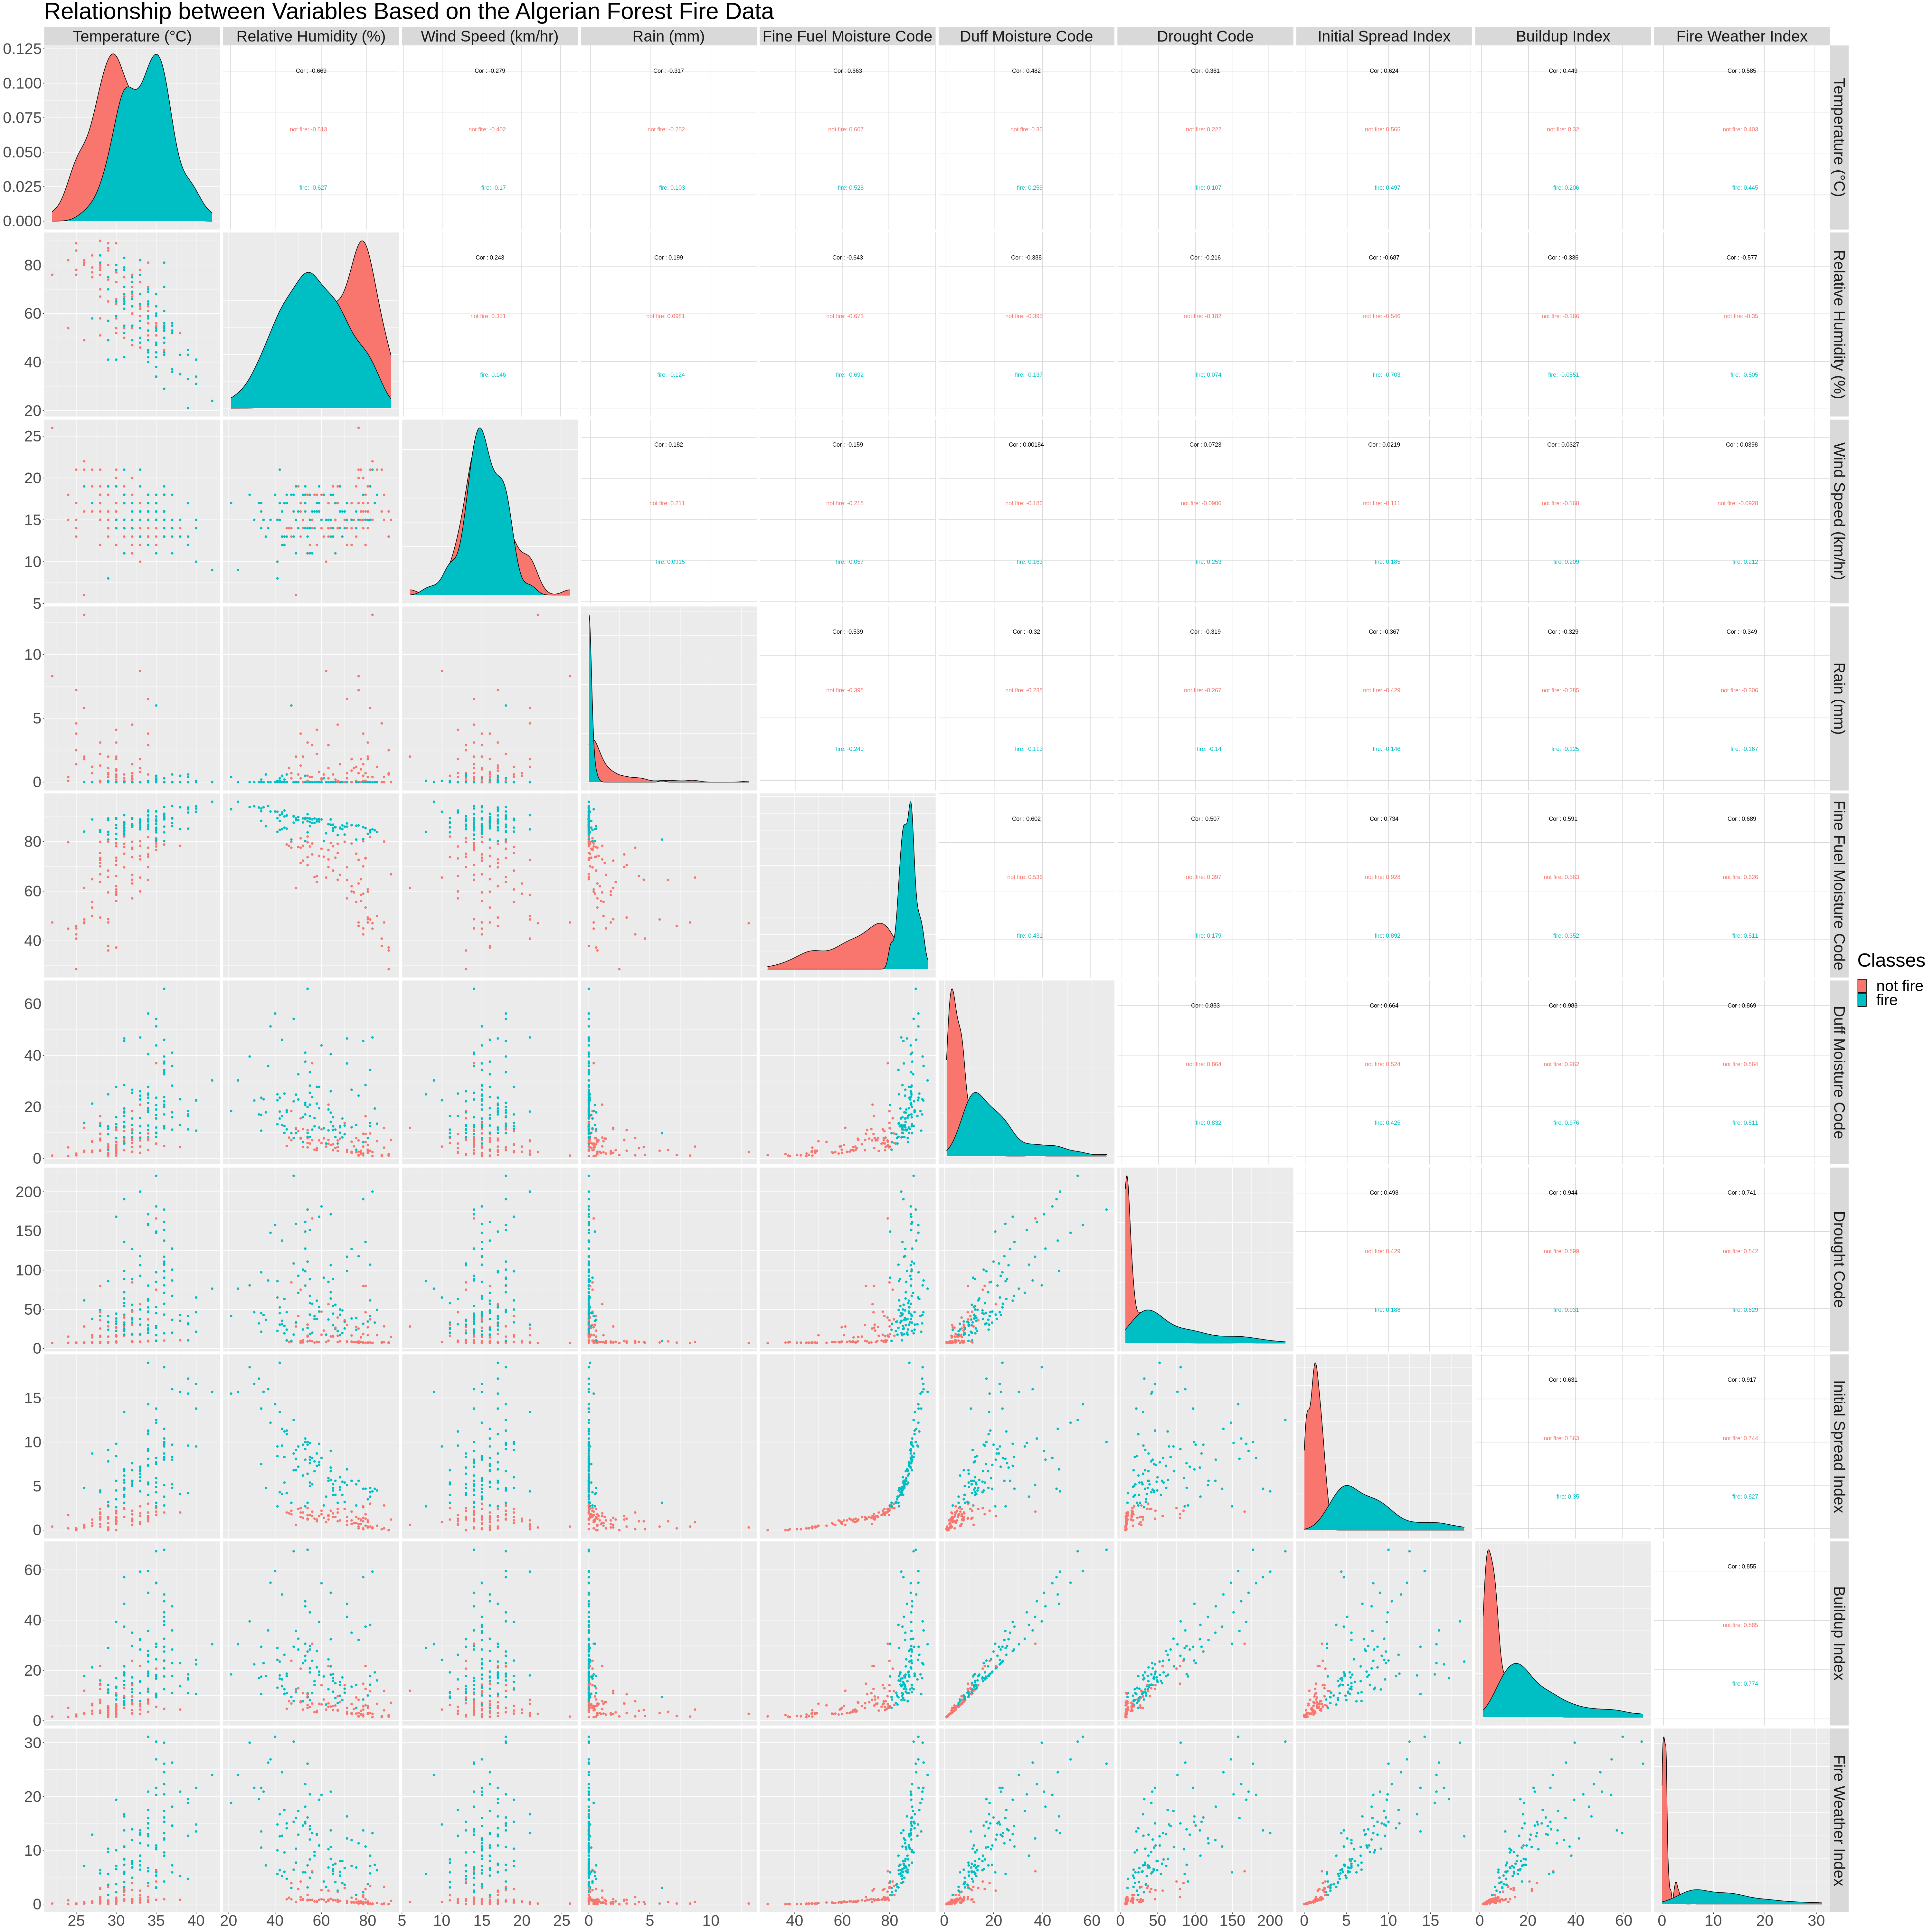

In [4]:
options(repr.plot.width=50, repr.plot.height=50)
forest_fire_graph <- forest_fire_train %>%
    ggpairs(columns =c('Temperature', 'RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI'),
            columnLabels=c('Temperature (°C)', 'Relative Humidity (%)','Wind Speed (km/hr)', 'Rain (mm)','Fine Fuel Moisture Code','Duff Moisture Code',
                           'Drought Code','Initial Spread Index', 'Buildup Index','Fire Weather Index'),
            legend=1,
           aes(color=Classes))+
    ggtitle("Relationship between Variables Based on the Algerian Forest Fire Data") + 
    theme(text=element_text(size=36))


forest_fire_graph


 <font color='grey'>Figure 1: Plots based on the various variables in the Algerian Forest Fires Dataset</font> 

Based on the graph, the variables with the strong correlation found in our initial exploratory graph will be chosen.  The following variables are:
- Duff Moisture Code `DMC`  from 1.1 to 65.9  
- Drought Code `DC`  from 7 to 220.4  
- Initial Spread Index `ISI`  from 0 to 18.5  
- Buildup Index `BUI`  from 1.1 to 68  
- Fire Weather Index `FWI`  from 0 to 31.1


This data analysis will be conducted with the classification method. The chosen variables will determine if an instance of potential fire will be classified as `fire` or `not fire` to determine whether a fire was present.


Our data analysis will be conducted in two main steps: Finding the $K$ value  through fold cross valiadation and then computing the accuracy of our prediction. The 5 fold cross validation will be chosen based on computational capability. Furthermore, the 5 fold validation will be passed in tuning in order to allows us to chose the optimal K to utilize. 

Finally using our $K$, we will predict our trained data through a classification workflow and then compute the accuracy of the prediction. The results of accuracy will be visualized through the form of a bar graph showing the percentages of correct predictions per predictor. 





#### Data Analysis: Choosing the K Value

Our initial step in our data analysis was to find  the most accurate $K$ value to use in our analysis. This was conducted in three steps:

First, we used the `nearest_neighbor` function and passed in the `tune()` function to tune our nearest neighbor model.

In [5]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Since K-NN classification predicts the classes of `fire` or `not_fire` by identifying nearby observations, it is imperative to ensure that variables with a larger value will not influence the other datapoints with a smaller value. Thus, we created a recipe and scaled the variables we chose in `forest_fire_train` Note that this recipe is to be reused in our data analysis after finding the $K$ value.

 

In [6]:
forest_fire_recipe <- recipe(Classes ~ DMC + DC + ISI + BUI + FWI, data = forest_fire_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
forest_fire_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we conducted both a 5-fold and 10-fold cross validation to divide the training data into 5 and 10 folds respectively (see Table 2 and Table 3). Each fold in the total number of folds will be given the oportunity to be a validation set. This is to prevent parts of the training data from being underrepresented and minimize selection bias.


In [7]:
forest_fire_vfold_5 <- vfold_cv(forest_fire_train, v = 5, strata = Classes)

forest_fire_results_5 <- workflow() %>%
  add_recipe(forest_fire_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = forest_fire_vfold_5, grid = 10) %>%
  collect_metrics()
head(forest_fire_results_5)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9509009,5,0.005338255,Model01
2,roc_auc,binary,0.9711310,5,0.013206374,Model01
3,accuracy,binary,0.9507508,5,0.010398914,Model02
3,roc_auc,binary,0.9875000,5,0.006796540,Model02
4,accuracy,binary,0.9507508,5,0.010398914,Model03
4,roc_auc,binary,0.9907292,5,0.006362786,Model03


 <font color='grey'>Table 2: 5- Fold cross validation results</font> 

In [8]:
forest_fire_vfold_10 <- vfold_cv(forest_fire_train, v = 10, strata = Classes)

forest_fire_results_10 <- workflow() %>%
  add_recipe(forest_fire_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = forest_fire_vfold_10, grid = 10) %>%
  collect_metrics()


head(forest_fire_results_10)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9406433,10,0.020064957,Model1
2,roc_auc,binary,0.9742614,10,0.009932642,Model1
4,accuracy,binary,0.9570175,10,0.015367808,Model2
4,roc_auc,binary,0.9827841,10,0.007832327,Model2
6,accuracy,binary,0.9514620,10,0.016809404,Model3
6,roc_auc,binary,0.9907386,10,0.006729777,Model3


 <font color='grey'>Table 3: 10- Fold cross validation results</font> 

Finally, we select the best value of the number of neighbours by filtering out the maximum mean in Table 2 and Table 3 (See Table 4 and 5). 

In [9]:
accuracies_5 <- forest_fire_results_5 %>%
    filter(.metric == "accuracy") %>%
    filter(mean == max(mean))
accuracies_5 #knn nearest neighbour for highest accuracy with a 5-fold cross-validation

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.9836336,5,0.006682947,Model05
8,accuracy,binary,0.9836336,5,0.006682947,Model06


 <font color='grey'>Table 4: The nearest-neighbour for the 5-fold cross validaiton result based on the highest mean.</font> 

In [10]:
accuracies_10 <- forest_fire_results_10 %>%
    filter(.metric == "accuracy") %>%
    filter(mean == max(mean)) 
accuracies_10   #knn nearest neighbor for highest accuracy with a 10-fold cross-validation

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.9616959,10,0.01414733,Model5
12,accuracy,binary,0.9616959,10,0.01414733,Model6


 <font color='grey'>Table 5: The nearest-neighbour for the 10-fold cross validaiton result based on the highest mean.</font> 

Table 4 shows that when $C = 5$ (i.e. 5-fold cross-validation), the k nearest neighbor with the highest accuracy is $K = 7$ and $K= 8$. IN contrast, Table 5 shows that when $C = 10$ (i.e. 10-fold cross-validation), the k nearest neighbors with the equally high accuracies are both $K = 11$ and $K = 12$.

Comparing both Tables 4 and 5, we see that $K= 7$ and $K=8$  has a lower standard error, as well as better accuracy than $K = 11$ and $K=12$. Therefore, using a 5-fold cross validation with $K = 7$ the best model for our classifier which we will use to predict the classes of fire in our testing data (we chose the odd number to avoid ties). Furthermore, the computation power was sufficient enough to handle a 5 fold cross validation but started to slow down when using a 10 Fold Cross Validation. 


#### Data Analysis: Predicting the Testing Data

With the $K$ value chosen as $7$, we once again called the `nearest_neighbor` function to create our classification specification by using $K=7$ with our engine being `kknn` and our mode to be `classificaiton`.

In [22]:
forest_fire_spec<- nearest_neighbor(weight_func = 'rectangular', neighbors = 7) %>%
       set_engine('kknn') %>%
       set_mode('classification')

Next, we added the recipe and the model together in a workflow. Futhermore, we specified that the whole workflow will be applied to the training dataset using the `fit` function. This will make a formula to prepare us to predict the classifiers with the testing data

In [23]:
forest_fire_fit<- workflow() %>%
          add_recipe(forest_fire_recipe) %>%
          add_model(forest_fire_spec) %>%
          fit(data=forest_fire_train)

forest_fire_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~7, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04371585
Best kernel: rectangular
Best k: 7

### Results

We called our `forest_fire_test` data to predict against the formula that we created above. In order to observe the effectiveness of the prediciton, we binded the columns of the predicted class with the actual classes found in the training data (See Table 6).

In [24]:
forest_fire_predictions <-predict(forest_fire_fit , forest_fire_test) %>%
       bind_cols(forest_fire_test)
head(forest_fire_predictions)

.pred_class,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not fire,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
not fire,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
not fire,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
not fire,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
fire,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire
fire,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire


 <font color='grey'>Table 6: Values of the predicted Class binded with the Classes from the training data</font> 

To ensure a hollistic view of the effectiveness of the formula, we used the `metrics` function to retrieve the statistics on the quality of our formula. The accuracy on the test data was 97% (See Table 7)

In [25]:
forest_fire_metrics<- forest_fire_predictions %>%
         metrics(truth = Classes, estimate = .pred_class)  
head(forest_fire_metrics)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9726776
kap,binary,0.9445555


 <font color='grey'>Table 7: Accuracy on the formula predicted on `forest_fire_test`</font> 

From Table 7, it is shown that our classifier accuracy is 97.27% effective. Due to the limitations of plotting multiple variables on a graph, we provided a graph showing the accuracy vs K plot using the 5-Fold Cross validation compared with the accuracy vs 10-fold Cross validation plot as an alternative (See Figure 2). This furthers confirms our choice of  𝐾  in Table 4 as the accuracy estimate (found in the y-axis) for the 5 fold cross validation is higher than the accuracy estimate in the 10 fold cross validation. It is assessed that the higher accuracy estimate found in the 5-fold most likely contributed to our accuracy of our classifier found in Table 7.

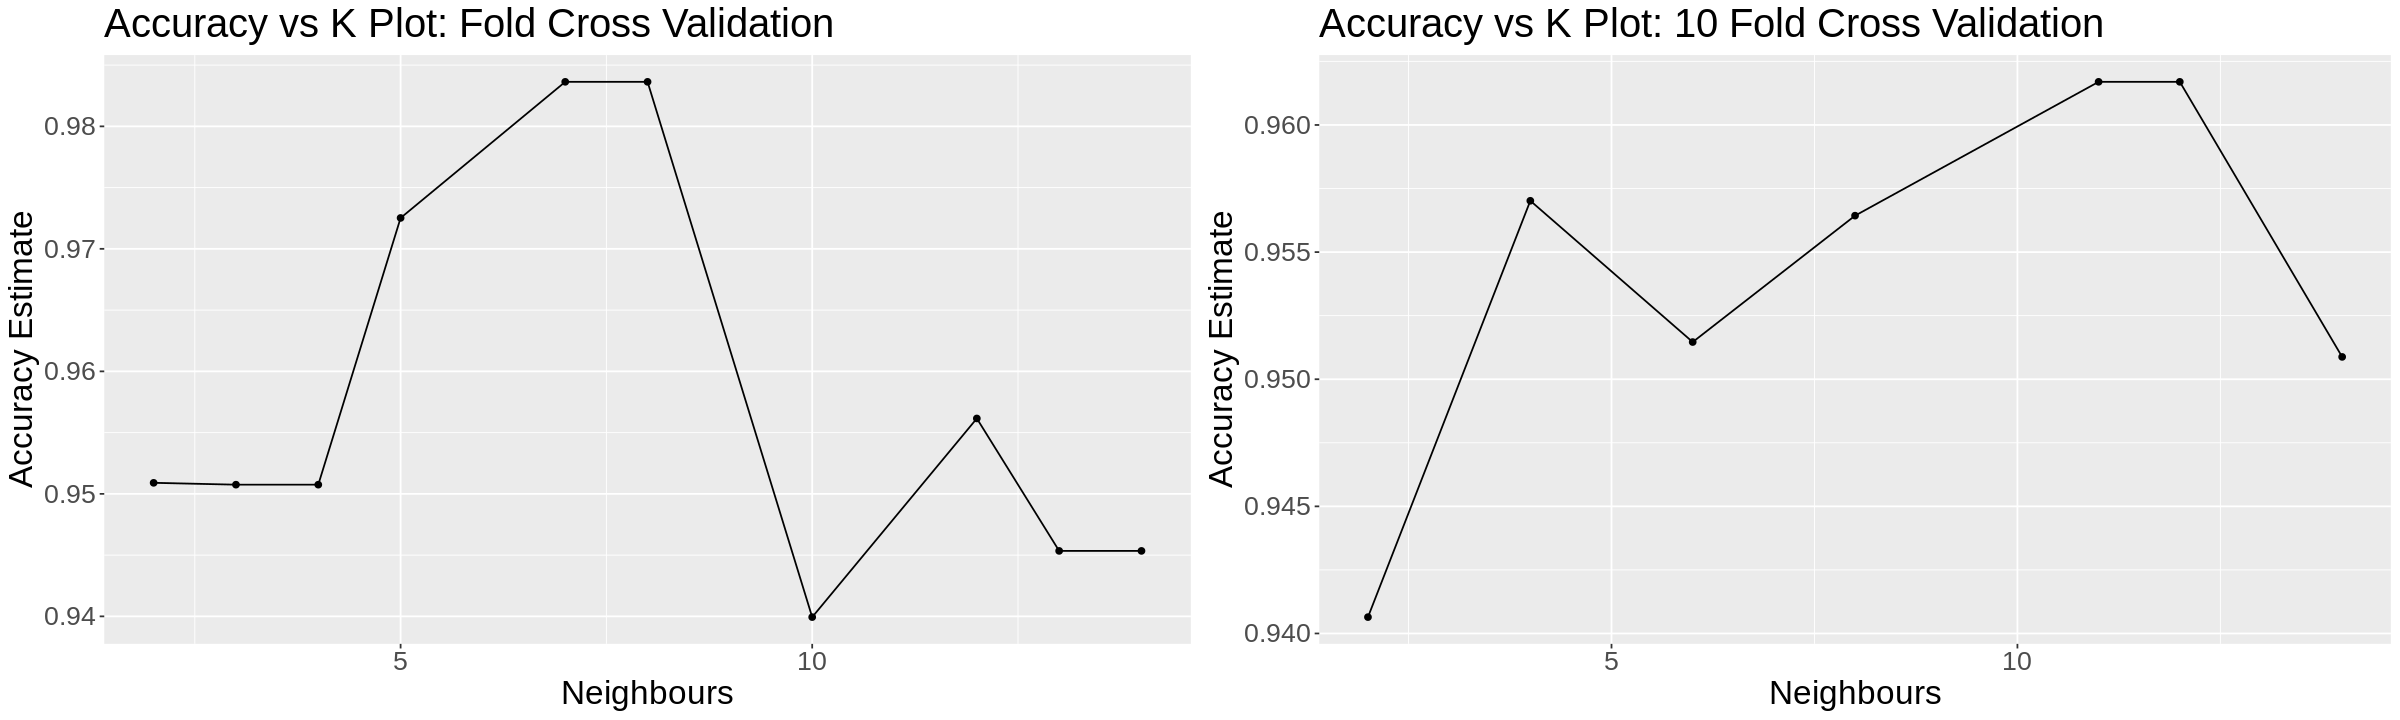

In [26]:
options(repr.plot.width = 20, repr.plot.height = 6) 

 accuracies_5_plot <- forest_fire_results_5 %>%
     filter(.metric == "accuracy") %>%
     ggplot(aes(x=neighbors,y=mean))+
     geom_point()+
     geom_line()+
     labs(x='Neighbours', y= 'Accuracy Estimate')+
     ggtitle('Accuracy vs K Plot: Fold Cross Validation')+
    theme(text = element_text(size = 20))

 accuracies_10_plot <- forest_fire_results_10 %>%
     filter(.metric == "accuracy") %>%
     ggplot(aes(x=neighbors,y=mean))+
     geom_point()+
     geom_line()+
     labs(x='Neighbours', y= 'Accuracy Estimate')+
     ggtitle('Accuracy vs K Plot: 10 Fold Cross Validation')+
    theme(text = element_text(size = 20))



fina_k_plot<- plot_grid(accuracies_5_plot,accuracies_10_plot, ncol=2)
fina_k_plot

 <font color='grey'>Figure 2: Accuracy vs K Plot for 5 Fold Cross Validation compared with Accuracy vs K Graph for 10 Fold Cross validation</font> 

### Discussion:
We expect to find that the predictors we have indicated will allow us to infer where forest fires may occur in Algeria. These findings could lead to increased knowledge and proactivity in stopping forest fires that may occur in areas with similar predictor values to regions that have experienced forest fires. A future question that may arise from this proposal would be determining which predictor variable would most greatly influence the likelihood of forest fires.